## FITS manipulation

File showing basic functionality of reading and manipulating FITS files. To build training set for a neural network, sigma clipping and image rotation are both important. Removing background noise helps the NN to more easily recognise the important features in images, and provide more consistency between images of the same object type and between different surveys. Rotating images allows for augmenting a training set and provides more rotational symmetry.

### Contents

1. [Example FITS image](#example)
2. [Example FIRST image, log color scale, Dec and RA coords](#FIRST)
3. [Sigma clipping](#sigma)
4. [Extract bright objects](#objects)
5. [Rotating objects](#rotate)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

from astropy.io import fits
from astropy import stats
from scipy.ndimage import rotate

# for interactive plots (inline or notebook)
%matplotlib inline

<a id='example'></a>
### 1. Download and plot example FITS image

Basic example of reading headers and data from a FITS file, and the different HDUs that can be contained within one file.

In [2]:
from astropy.utils.data import get_pkg_data_filename
image_file = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')

In [3]:
hdul = fits.open(image_file) # 'header data unit list'
hdul.info() # summarizes the content of the opened FITS file
# each element of hdul is a HDU with attributes .data and .header
data = hdul[1].data
header = hdul[1].header
hdul.close() # could use with statement for automatic closing

Filename: C:\Users\JakeM\.astropy\cache\download\py3\2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


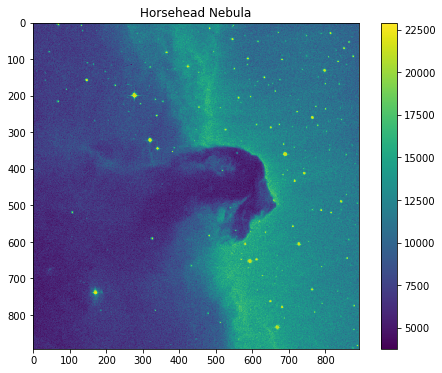

In [4]:
image_data = fits.getdata(image_file, ext=0) # gets data without opening file, alt: hdul[0].data
plt.figure(figsize=(8,6))
plt.imshow(image_data, cmap='viridis') # colours, eg. 'gray', 'inferno' etc...
plt.colorbar()
plt.title('Horsehead Nebula')
plt.show()

<a id='FIRST'></a>
### 2. Example AGN data from VLA

Pixel values are given in mJy/beam, could convert to mJy, which should also remove flux negative values.

Want to convert mJy/beam to mJy, something to do with Gaussian beam size, major and minor beam axis, 
how many arcsec / pixel, pixels/beam, FWHM in pixels, astropy might have useful unit conversions 
e.g. Jy/beam to Jy/sr (solid angle), or to temperature, negative flux is possible due to process of interferometry / fourier transform to combine the data from different receivers, in the low frequency limit (valid for radio astronomy), we can use the Rayleigh-Jeans approximation, which can convert from brightness temperature to Flux density, see USEFUL bookmark...

This example image actually has zeros around edge of image, probably because image was on the boundary of the survey or boundary of particular image in survey.

In [6]:
# FITS file from FIRST survey, using VLA radio telescope
image_file = '../Data/J105007+304037.fits'
hdul = fits.open(image_file)
hdul.info()
image_data = hdul[0].data
header = hdul[0].header
hdul.close()
#header

Filename: ../Data/J105007+304037.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     103   (1024, 1024)   float32   


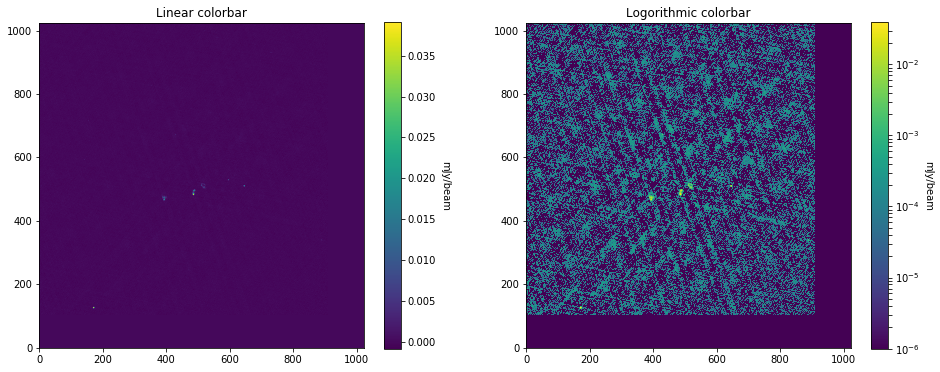

In [7]:
# Plot image with different colorbar scales
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,6))
im1 = ax1.imshow(image_data, cmap='viridis', origin='lower')

thresh = 10**-6
log_image_data = np.copy(image_data)
# Removes values below a threshold, deals with negative flux, so can plot log colour scale
log_image_data[log_image_data<thresh] = thresh

im2 = ax2.imshow(log_image_data, cmap='viridis', origin='lower', norm=colors.LogNorm())

cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label('mJy/beam', rotation=-90, va='bottom')
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label('mJy/beam', rotation=-90, va='bottom')

ax1.set_title('Linear colorbar')
ax2.set_title('Logorithmic colorbar')
plt.show()

<a id='sigma'></a>
### 3. Sigma clipping of image

To sigma clip images find the median and std_dev of the image after sigma clipping (removing values far from the median), this gives the stats related to the background of the image. Can then remove the background by setting values up to a certain number of std_devs away from the median to the desired background value.

Shows background looks like normal ditribution, peak at zero because of edge values.

In [8]:
# The stats of the image after sigma clipping, i.e. the stats of the background distribution
mean, median, std_dev = stats.sigma_clipped_stats(image_data, sigma=3)
# Stats of sigma_clip array are equivalent to stats above
#sigma_clipped_data = stats.sigma_clip(image_data, sigma=3)

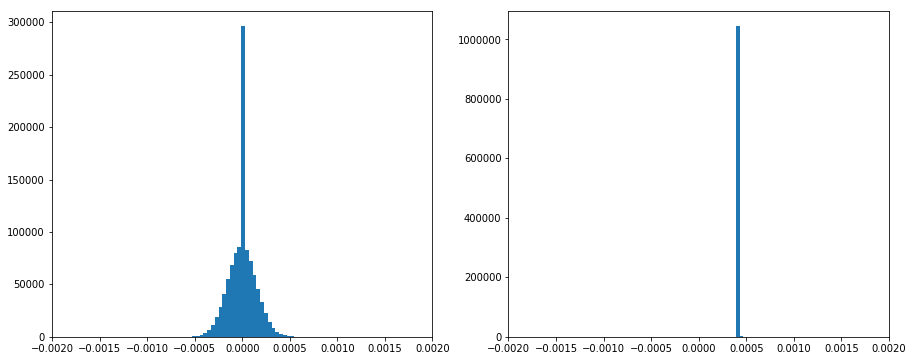

In [10]:
# Sets everything above 3 sigma from the median of the background to a fixed value
clipped_image_data = np.copy(image_data)
clipped_image_data[clipped_image_data<median+3*std_dev] = median+3*std_dev

# Histograms to show comparison of the background pixel values before and after sigma clipping
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.hist(image_data.flatten(), bins = 1000, rwidth = 1)
#ax1.set_ylim(0,20)
ax1.set_xlim(-0.002, 0.002)
ax2.hist(clipped_image_data.flatten(), bins = 1000, rwidth = 1)
#ax2.set_ylim(0,20)
ax2.set_xlim(-0.002, 0.002)
plt.show()

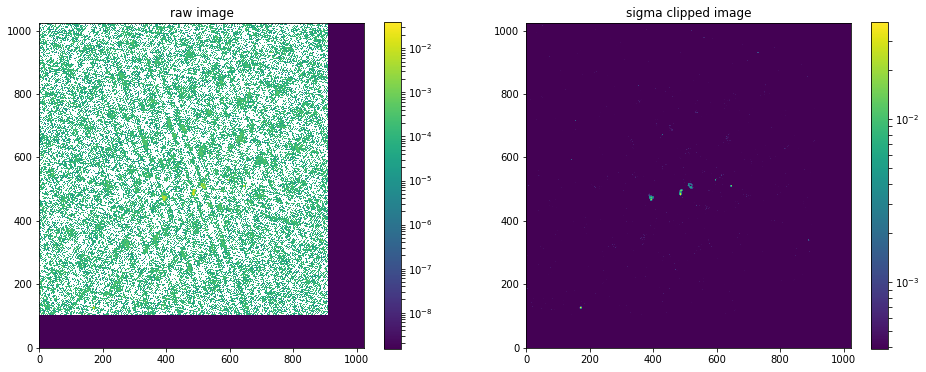

In [11]:
# Plot raw image and sigma clipped image
# Plotted on log scale so difference is clear
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,6))

cmap = 'viridis'
im1 = ax1.imshow(image_data, cmap=cmap, origin='lower', norm=colors.LogNorm())
im2 = ax2.imshow(clipped_image_data, cmap=cmap, origin='lower', norm=colors.LogNorm())

cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)

ax1.set_title('raw image')
ax2.set_title('sigma clipped image')
plt.show()

<a id='objects'></a>
### 4. Extract bright objects from the image

Simple (and inefficient) source finder, so find bright pixels in the image and extract the region around them.

In [12]:
# Find coords of brightest objects
data = log_image_data # or image_data --> need to change norm param in imshow()
copy = np.copy(data)
vmin, vmax = np.min(data), np.max(data) # used so each image has same colourmap
s = 24 # size of object to be cropped (half width)
objs = [] # empty list to store obj coords in

#! need exception for when object is in corner of image
while len(objs) < 10:
    y,x = np.unravel_index(copy.argmax(), copy.shape) # need to unravel 1D index from argmax() to get 2D index
    objs.append((y,x))
    copy[y-s:y+s, x-s:x+s] = vmin # 'deletes' obj from copy so next obj can be found

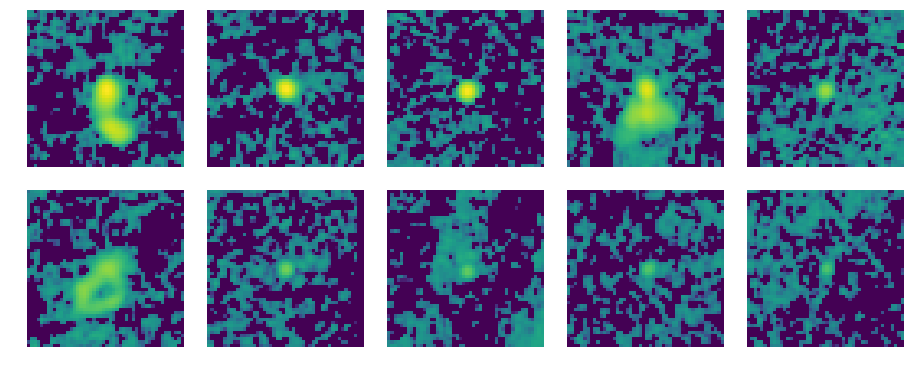

In [13]:
n = len(objs) # number of objects to plot
cols = 5 # number of objects per row
rows = (n+cols-1)//cols # number of required rows in figure (division that rounds up)

# Plots objects
fig = plt.figure(figsize=(12.5,rows*2.5))
for i in range(len(objs)):
    ax = fig.add_subplot(rows, cols, i+1)
    y,x = objs[i]
    # need vmin and vmax to have the same colormap as the full image
    ax.imshow(data[y-s:y+s, x-s:x+s], cmap='viridis', vmin=vmin, vmax=vmax, norm=colors.LogNorm()) # norm=colors.LogNorm()
    plt.axis('off')

fig.tight_layout(pad=0)
plt.show()

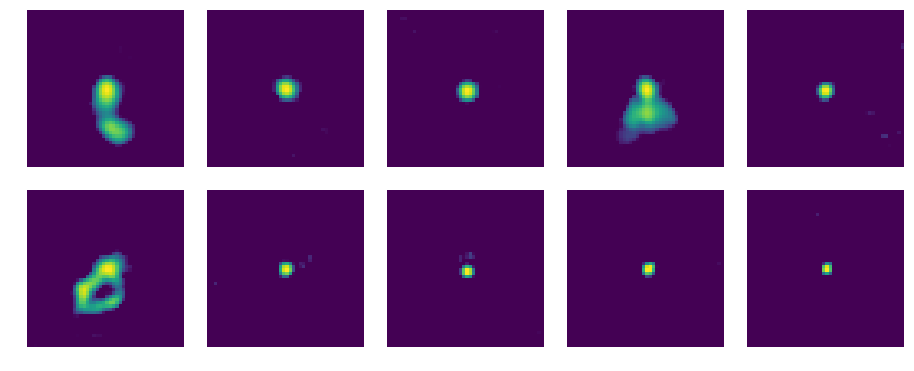

In [14]:
# Sigma clip objects
# Each image here has it's own colourmap... (unlike above)
n = 3
fig = plt.figure(figsize=(12.5,rows*2.5))
for i in range(len(objs)):
    ax = fig.add_subplot(rows, cols, i+1)
    y,x = objs[i]
    d = np.copy(image_data[y-s:y+s, x-s:x+s])
    _,median,std = stats.sigma_clipped_stats(d, sigma=3)
    d[d<median+n*std] = median+n*std
    ax.imshow(d, cmap='viridis', norm=colors.LogNorm())
    plt.axis('off')

fig.tight_layout(pad=0)
plt.show()

<a id='rotate'></a>
### 5. Rotating objects

Roating images example, using scipy.ndimage.rotate

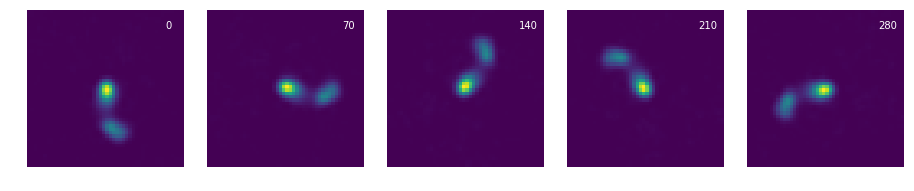

In [15]:
# Rotate brightest object
y,x = objs[0]
im = data[y-s:y+s, x-s:x+s]

fig, ax = plt.subplots(1,5, figsize = (12.5,2.5))
for i in range(5):
    # for 2D array of images (3x3) use ax[i//3,i%3]
    rot = rotate(im, i*70, reshape=False)
    ax[i].imshow(rot)
    ax[i].text(0.9, 0.9, i*70, horizontalalignment='center', verticalalignment='center',
                      transform=ax[i].transAxes, color='w')
    ax[i].axis('off')
fig.tight_layout(pad=0)
plt.show()